In [82]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import curve_fit

In [83]:
temperature_data = pd.DataFrame({
    "t, °C": [
        35.0, 35.0, 35.0, 35.0, 35.0, 35.0, 35.0,
        37.0, 37.0, 37.0, 37.0, 37.0, 37.0, 37.0,
        40.0, 40.0, 40.0, 40.0, 40.0, 40.0, 40.0,
        45.0, 45.0, 45.0, 45.0, 45.0, 45.0, 45.0
    ],
    "Time": [
        0.0, 4.0, 8.0, 12.0, 16.0, 20.0, 24.0,
        0.0, 4.0, 8.0, 12.0, 16.0, 20.0, 24.0,
        0.0, 4.0, 8.0, 12.0, 16.0, 20.0, 24.0,
        0.0, 4.0, 8.0, 12.0, 16.0, 20.0, 24.0
    ],
    "OpticalDensity": [
        0.086266, 0.224488, 0.646507, 0.930303, 0.952850, 1.025000, 1.002845,
        0.090474, 0.235439, 0.678044, 0.975684, 0.999331, 1.075000, 1.051765,
        0.087108, 0.226678, 0.652814, 0.939379, 0.962146, 1.035000, 1.012629,
        0.073642, 0.191636, 0.551896, 0.794161, 0.813409, 0.875000, 0.856087
    ]
})

In [84]:
# Compute normalized temperature coefficients using final OD ratio vs 37°C
# Final OD per temperature at the last timepoint
final_by_temp = (
    temperature_data.sort_values('Time')
    .groupby('t, °C')['OpticalDensity']
    .agg(lambda s: s.iloc[-1])
)
baseline_final = final_by_temp.loc[37.0]
coeff = final_by_temp / baseline_final

In [85]:
# Fit a smooth Gaussian-like curve m(temperature) with m(37)=1.0
def m_model(temperature: np.ndarray, sigma: float, floor: float, temperature_optimal: float = 37.0):
    return (
        floor + (1.0 - floor) *
        np.exp(-((temperature - temperature_optimal) ** 2) / (2.0 * sigma ** 2))
    )


Ts = coeff.index.to_numpy()
ys = coeff.to_numpy()

In [86]:
p0 = [3.0, 0.6]
bounds = ([0.1, 0.0], [20.0, 0.999])

(sigma_hat, floor_hat), _ = curve_fit(m_model, Ts, ys, p0=p0, bounds=bounds, maxfev=20000)

print(f"Fitted m(temperature): sigma={sigma_hat:.4f}, floor={floor_hat:.4f}")

for temperature in [35.0, 37.0, 40.0, 45.0]:
    print(f"  m_fit({temperature:.1f}°C) = {m_model(temperature, sigma_hat, floor_hat):.6f}")

Fitted m(temperature): sigma=4.2358, floor=0.7768
  m_fit(35.0°C) = 0.976458
  m_fit(37.0°C) = 1.000000
  m_fit(40.0°C) = 0.950491
  m_fit(45.0°C) = 0.814320


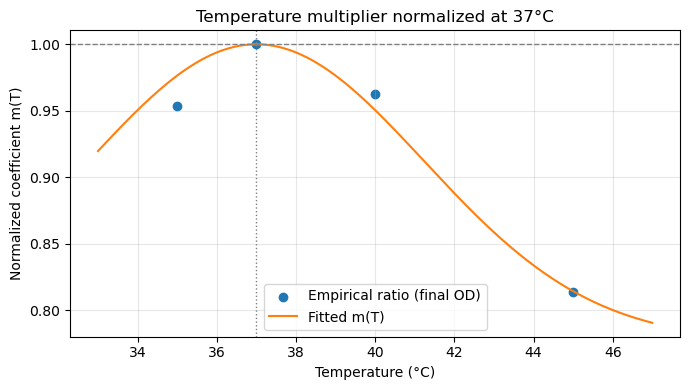

In [87]:
plt.figure(figsize=(7, 4))
plt.scatter(Ts, ys, color='C0', label='Empirical ratio (final OD)')
if sigma_hat is not None:
    T_grid = np.linspace(33, 47, 200)
    plt.plot(T_grid, m_model(T_grid, sigma_hat, floor_hat), 'C1-', label='Fitted m(T)')
plt.axhline(1.0, color='gray', linestyle='--', linewidth=1)
plt.axvline(37.0, color='gray', linestyle=':', linewidth=1)
plt.xlabel('Temperature (°C)')
plt.ylabel('Normalized coefficient m(T)')
plt.title('Temperature multiplier normalized at 37°C')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()